# ALS Project

## FVC measurements

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [31]:
from eda_functions import *
from collections import defaultdict
from scipy.stats import linregress

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##

In [7]:
fvc = pd.read_csv("data/Fvc.csv")

In [8]:
fvc.head()

,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Forced_Vital_Capacity_Delta,Subject_Normal,Forced_Vital_Capacity_Units
0,89,2.89,NaN,NaN,NaN,NaN,NaN,0.0,3.83,NaN
1,329,2.49,97.0,2.57,NaN,2.60,NaN,0.0,NaN,NaN
2,329,2.71,101.0,2.62,NaN,2.72,NaN,16.0,NaN,NaN
3,329,2.75,103.0,2.62,NaN,2.53,NaN,42.0,NaN,NaN
4,329,2.79,104.0,2.62,NaN,2.61,NaN,72.0,NaN,NaN


In [9]:
# change Forced_Vital_Capacity_Delta to study day
fvc['study_day'] = fvc['Forced_Vital_Capacity_Delta']

In [10]:
fvc.drop('Forced_Vital_Capacity_Delta', axis=1, inplace=True)

In [11]:
# plot each FVC score
Qs=['Subject_Liters_Trial_1']

def plot_fvc_long(df):
    if len(df)> 200:
        return "df is too long"
    plt.figure(figsize=(12,6))
    for feature in df[Qs]:
        if np.all(df[feature].isnull()):
            continue
        plt.plot(df['study_day'], df[feature])
    plt.title("FVC, first attempt, subject={}".format(df['subject_id'].unique()))
    plt.ylabel("Liters")
    plt.xlabel("study day")
    plt.show()

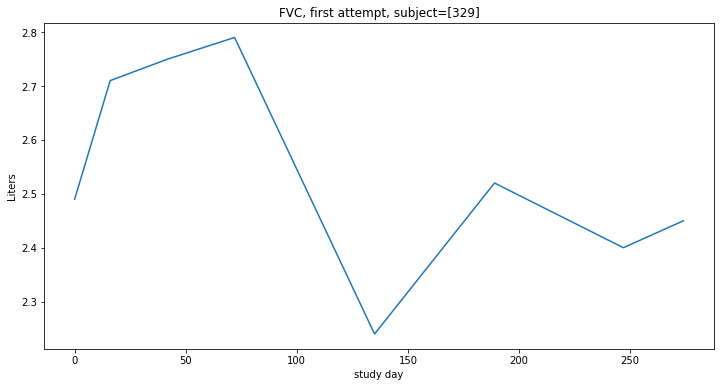

In [14]:
subject = fvc[ fvc['subject_id']==329]
plot_fvc_long(subject)

/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


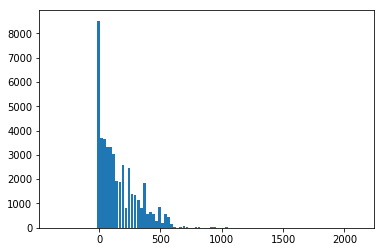

In [15]:
# hist of study days for fvc
plt.hist(fvc['study_day'], bins=100, rwidth=0.9)
plt.show()

In [17]:
fvc.head()

,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day
0,89,2.89,NaN,NaN,NaN,NaN,NaN,3.83,NaN,0.0
1,329,2.49,97.0,2.57,NaN,2.60,NaN,NaN,NaN,0.0
2,329,2.71,101.0,2.62,NaN,2.72,NaN,NaN,NaN,16.0
3,329,2.75,103.0,2.62,NaN,2.53,NaN,NaN,NaN,42.0
4,329,2.79,104.0,2.62,NaN,2.61,NaN,NaN,NaN,72.0


In [18]:
# add the onset date data
onset = pd.read_csv("clean_data/onset_date.csv")

In [19]:
fvc_onset = fvc.merge(onset, how='left', on='subject_id')

In [24]:
fvc_onset['day_since_onset']= np.abs(fvc_onset['Onset_Delta']) + fvc_onset['study_day']
print(fvc_onset.shape)
fvc_onset.head()

(48856, 13)


,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Subject_Normal,Forced_Vital_Capacity_Units,study_day,Onset_Delta,Diagnosis_Delta,day_since_onset
0,89,2.89,NaN,NaN,NaN,NaN,NaN,3.83,NaN,0.0,NaN,NaN,NaN
1,329,2.49,97.0,2.57,NaN,2.60,NaN,NaN,NaN,0.0,-1706.0,-1068.0,1706.0
2,329,2.71,101.0,2.62,NaN,2.72,NaN,NaN,NaN,16.0,-1706.0,-1068.0,1722.0
3,329,2.75,103.0,2.62,NaN,2.53,NaN,NaN,NaN,42.0,-1706.0,-1068.0,1748.0
4,329,2.79,104.0,2.62,NaN,2.61,NaN,NaN,NaN,72.0,-1706.0,-1068.0,1778.0


## Slopes for FVC measurements

In [29]:
subject_col='subject_id'
y_col1='pct_of_Normal_Trial_1'
x_col='day_since_onset'

# the dataframe
df = fvc_onset.copy()

# list of every subject in table 
subjects_list = list(np.unique(df[subject_col]))

In [32]:
#def linreg_scalers(df, subjects_list, subject_col, y_col1, y_col2, x_col):
'''
saves linear regression slopes, intercepts for every subject in a df.
input:
    df = df
    subjects_list = list of unique subject names
    subject_col = name of subject id column
    y_col1 = name of first y data column
    x_col = name of column with x values 
output:
    regression outputs in dataframe
'''
slopes = defaultdict()
# for each subject
for subj in subjects_list:
    data = df.loc[ df[subject_col]==subj].copy()
    y1=data[y_col1]
    x=data[x_col]

    # if only one record then skip
    if len(data)==1:
        continue
    # if missing values in x or y then skip
    if ~(y1.isnull().any())  or (x.isnull().any()):
        y=np.array(y1)
        x=np.array(x)
        # linregress is part of scipy.stats. 
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        slopes[subj] = ('fvc percent of normal',slope,intercept)

# return the dictionary as a formated dataframe
linreg_fvc = pd.DataFrame(slopes).transpose().reset_index()

In [34]:
# relabel columns
linreg_fvc.rename(index=str, columns={"index": "subject_id", 0: "test" ,1: "slope", 2: "intercept"}, 
          inplace=True)

In [35]:
print(linreg_fvc.shape)
linreg_fvc.head()
# note 377 missing subjects. presume only had one value??

(4273, 4)


,subject_id,test,slope,intercept
0,329,fvc percent of normal,-0.039142,169.547
1,533,fvc percent of normal,-0.583333,676.75
2,708,fvc percent of normal,-0.0954166,157.255
3,902,fvc percent of normal,-0.0497421,119.206
4,1608,fvc percent of normal,NaN,NaN


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

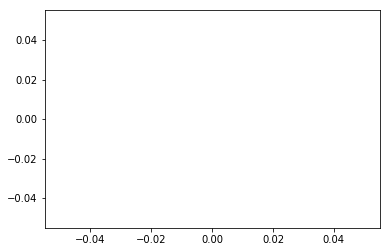

In [36]:
# plot a few subject's points with linear regression line
# note: only takes one assessment
subj10 = subjects_list[0:10]
for subj in subj10:
    points = fvc_onset[ fvc_onset['subject_id']==subj]
    line = linreg_fvc[ linreg_fvc['subject_id']==subj]
    plt.plot(points['day_since_onset'].values, points['pct_of_Normal_Trial_1'].values)
    plt.plot(points['day_since_onset'].values,
             line['intercept'].values + line['slope'].values * points['day_since_onset'].values, 
             '-')
    plt.title("{} {}".format(subj,line['scale'].values))
    plt.ylim(8,56)
    plt.show()

In [16]:
# save the clean file
filename = 'clean_data/fvc.csv'
fvc.to_csv(filename, index=False)